In [1]:
import pandas as pd
from langdetect import detect as detect_language

In [9]:
data = pd.read_csv("patents2016_epo_with_language.csv", sep=",", 
                   index_col=0,
                   names=["id", "abstract", "language"])[1:]

/Users/arnaudmiribel/anaconda/envs/ada/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
data = data.set_index("id")

In [13]:
data.head()

,abstract,language
id,,
448476353,La présente invention se rapporte à un procédé...,fr
448078788,The invention relates to a circuit assembly (1...,en
448476383,We describe apparatus for controlling the filt...,en
448078784,Minimally-invasive spinal inventions are often...,en
448476384,The present disclosure relates to nucleic acid...,en


In [157]:
import random
a = range(len(data[data.language == "en"]))
b = random.sample(a, 10000)

In [158]:
len(a)

37013

In [159]:
data_en = data[data.language == "en"].iloc[b]

In [160]:
len(data_en)

10000

In [161]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import stop_words
import string
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet

def get_wordnet_tag(treebank_tag):
    """ enables to map pos tags from treebank to wordnet valid pos tags 
    (in order to feed the lemmatizer) """
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:  # if starts with N or others (noun by default)
        return wordnet.NOUN
    
def lemmatize(token):
    """ final method to lemmatize using wordnet lemmatizer """
    
    trbk_tag = pos_tag([token])[0][1]  # get the treebank tag from pos_tag method
    wrdnt_tag = get_wordnet_tag(treebank_tag=trbk_tag)  # translate it to wordnet tag
    return lemmatizer.lemmatize(token, wrdnt_tag)

stop_words_ = stop_words.get_stop_words("en")
punctuation_filter = str.maketrans({key: None for key in string.punctuation})

def nlp_pre_process(text, lemma=False, stem=False):
    """
    Reduces an input text into a list of tokens, 
    using NLP filterings such as normalization, 
    PoS and stop word filtering, stemming.
    text: (str)
    tokens: list(str)
    """
    text = text.lower()  # normalize
    text = text.translate(punctuation_filter)  # remove punctuation
    tokens = word_tokenize(text)  # tokenize
    pos_tags = [pos_tag([t]) for t in tokens]  # PoS tagging
    tokens = [token for [(token, tag)] in pos_tags if tag != "DT"]  # PoS filtering
    tokens = [t for t in tokens if t not in stop_words_]  # stop words filtering
    
    if stem:
        tokens = [stemmer.stem(t) for t in tokens]  # stemming
    
    if lemma:
        tokens = [lemmatize(t) for t in tokens]  # lemmatizing
    
    return " ".join(tokens)

In [162]:
data_en.abstract = data_en.abstract.apply(nlp_pre_process)

In [344]:
data_en.abstract.head()

id
457996397    systems methods provided reliable wireless gro...
458260670    provided method preparing new type recombinant...
458691106    accordance certain embodiments patterns formed...
456633555    shatter proof enclosure mount motion capture e...
457244625    present disclosure relates process apparatus p...
Name: abstract, dtype: object

In [345]:
data_en.to_csv("patents2016_preprocessed.csv")

In [2]:
data_en = pd.read_csv("patents2016_preprocessed.csv")

In [3]:
data_en.head()

,id,abstract,language
0,457996397,systems methods provided reliable wireless gro...,en
1,458260670,provided method preparing new type recombinant...,en
2,458691106,accordance certain embodiments patterns formed...,en
3,456633555,shatter proof enclosure mount motion capture e...,en
4,457244625,present disclosure relates process apparatus p...,en


# -------------- TOPIC EXTRACTION --------------

## If problem with textmining package : http://stackoverflow.com/questions/15717752/python3-3-importerror-with-textmining-1-0

In [4]:
%matplotlib inline
from textmining import TermDocumentMatrix
import numpy as np
import lda
from sklearn.manifold import TSNE
import seaborn as sns
import logging
import json
logging.getLogger("lda").setLevel(logging.WARNING)  # disable INFOs output from lda

Term Document Matrix

In [5]:
# ranges of documents.
ranges = {}
tdm = TermDocumentMatrix(tokenizer=lambda s: s.split(" "))
titles = []
count = 0
nlp_processed = data_en.abstract.values

for abstract in nlp_processed:
    abstract = abstract.split()
    titles.append(abstract[:40])
    tdm.add_doc(" ".join(abstract))

In [6]:
count = 0
X = []
for row in tdm.rows(cutoff=1):
    if count == 0:
        vocab = row
        count += 1
    else:
        X.append(row)
X = np.array(X)

In [7]:
N_TOPICS = 11
lda = lda.LDA(n_topics=N_TOPICS, n_iter=1500, random_state=1)
lda.fit(X)

In [8]:
X = lda.doc_topic_
X = np.concatenate((X, np.identity(N_TOPICS)), axis=0)  # add centroids

In [9]:
N_TOP_WORDS = 30
topic_word = lda.topic_word_
centroid_labels = []
for topic, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-N_TOP_WORDS:-1]
    centroid_label = ", ".join(topic_words[0:16])
    centroid_labels.append(centroid_label)

In [10]:
n_top_words = 16
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: device information data user system one first network method communication content second may access includes mobile
Topic 1: layer first substrate second material semiconductor electrode surface region includes formed film method structure conductive metal
Topic 2: image light unit display first optical device second sensor lens includes object one configured least beam
Topic 3: first second portion member end includes assembly one body housing position configured least element surface device
Topic 4: may can methods system systems andor include embodiments used devices using also disclosed use present invention
Topic 5: invention present composition comprising methods relates compositions one method group least acid also compound thereof agent
Topic 6: surface side part body end plate outer upper portion inner frame set wall front formed lower
Topic 7: fluid 2 1 flow chamber gas air 10 said 3 liquid 5 pressure water heat least
Topic 8: vehicle motor tool unit control positio

# -------------- DIMENSION REDUCTION --------------

 Fisher Linear Discriminant could be interesting see slide 29 http://www.cs.cmu.edu/~guestrin/Class/10701-S05/slides/dimensionality.pdf as it projects on the 

In [24]:
#http://stackoverflow.com/questions/23277958/how-to-run-and-interpret-fishers-linear-discriminant-analysis-from-scikit-learn
from sklearn.lda import LDA as fischerLDA
fischerLDA = fischerLDA(n_components=2)

# y must be the assignments. Suppose we say it is the topic that has maximum value in the distribution
y = list(np.argmax(X, axis=1))
X_fischerLDA = fischerLDA.fit_transform(X, y)

/Users/arnaudmiribel/anaconda/envs/ada/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [291]:
#from sklearn.decomposition import PCA
#model = PCA(n_components=2)
#X_tsne = model.fit_transform(X)

In [226]:
#X_tsne = TSNE(learning_rate=100).fit_transform(X)

In [293]:
X_tsne.shape

(10011, 2)

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.palettes import Viridis6
from bokeh.plotting import figure, show, output_notebook
import bokeh

Color palette we use : 


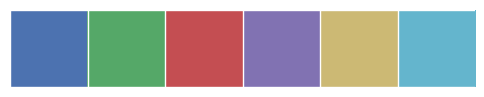

In [13]:
current_palette = sns.color_palette()
print("Color palette we use : ")
sns.palplot(current_palette)
current_palette = [(r*255,g*255,b*255) for (r,g,b) in current_palette]

our labels will be titles for the 500 first points and then centroid_labels

In [14]:
len(titles), len(centroid_labels)

(10000, 11)

In [15]:
output_notebook()

Loading BokehJS ...

In [16]:
titles = [" ".join(t) for t in titles]

In [17]:
bokeh.io.reset_output() # ultra important not to overcrowd the export
output_notebook(bokeh.resources.INLINE)  # enable bokeh to run inline in Jupyter
TOOLS="resize,crosshair,pan,wheel_zoom,box_zoom,reset,tap,previewsave,box_select,poly_select, hover, undo, redo"

# Create figure

p = figure(tools=TOOLS,plot_width=600, plot_height=300)

# Scatter data from politicians
source = ColumnDataSource(
                data = dict(
                        x=X_tsne[:,0], 
                        y=X_tsne[:,1],
                        qualifier=["Abstract"]*X_tsne.shape[0],
                        content=titles.append(centroid_labels))
                )

p.scatter('x', 'y', source=source, color="black")

# Scatter topics

a = X.shape[0] - N_TOPICS
b = X.shape[0]

source = ColumnDataSource(data=dict(
    x = X_tsne[a:b,0],
    y = X_tsne[a:b,1],
    qualifier=["Topic"]*(b-a),
    content = centroid_labels
    ))

p.scatter('x', 'y', source=source, color="red", marker="diamond", size=30, legend="Topic")
hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Type", "@qualifier"),
    ("Content", "@content")
]

Loading BokehJS ...

In [18]:
output_notebook()

Loading BokehJS ...

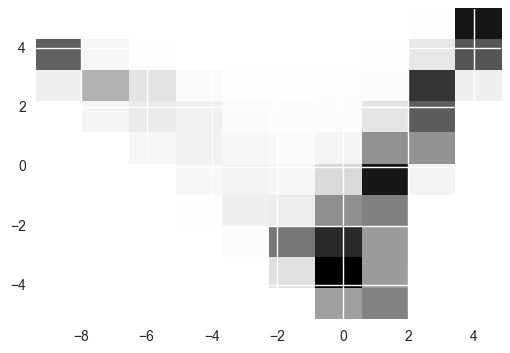

In [19]:
plt.hist2d(X_tsne[:,0], X_tsne[:,1]);

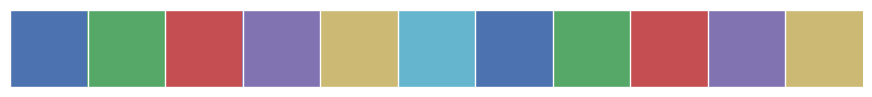

In [20]:
current_palette = sns.color_palette(n_colors = N_TOPICS)
sns.palplot(current_palette)

- Topic 0: device information data user system one first network method communication content second may access includes mobile
- Topic 1: layer first substrate second material semiconductor electrode surface region includes formed film method structure conductive metal
- Topic 2: image light unit display first optical device second sensor lens includes object one configured least beam
- Topic 3: first second portion member end includes assembly one body housing position configured least element surface device
- Topic 4: may can methods system systems andor include embodiments used devices using also disclosed use present invention
- Topic 5: invention present composition comprising methods relates compositions one method group least acid also compound thereof agent
- Topic 6: surface side part body end plate outer upper portion inner frame set wall front formed lower
- Topic 7: fluid 2 1 flow chamber gas air 10 said 3 liquid 5 pressure water heat least
- Topic 8: vehicle motor tool unit control position device drive magnetic one wheel system means shaft driving speed
- Topic 9: data one method based plurality set first value least block determining video using time includes selected
- Topic 10: signal first power second control circuit device unit includes output configured voltage one current signals frequency

# Visualizing centroids 

blue : looks like IT , electrical engineering abstracts (topics 0, 9, 10)  
orange : looks like physics (topics 2, 8)  
yellow : chemistry, materials (topics 1, 7)  
gray : trash topics (3, 4, 6, 5)  

In [38]:
current_palette = ["blue", "yellow", "orange", "gray", "gray", "gray", "gray", "yellow", "orange", "blue", "blue"]

In [41]:
def visualize_fischer_lda():
    
    # define colors
    colors = [current_palette[c] for c in y]
    
    # define bounds 
    a = X.shape[0] - N_TOPICS
    b = X.shape[0]
    
    # plot the abstracts projection
    plt.figure(figsize=(15,15))
    for i in range(len(data_en)):
        plt.scatter(X_fischerLDA[i,0], X_fischerLDA[i,1], c=colors[i])

    # plot the topic centroids
    plt.scatter(X_fischerLDA[a:b,0], X_fischerLDA[a:b,1], c=current_palette, marker="p", 
                linewidths=20, edgecolors="r", alpha=.8)

    # doing the legend
    import matplotlib.patches as mpatches
    patches = []
    for i,c in enumerate(current_palette):
        patches.append(mpatches.Patch(color=c, label=centroid_labels[i]))
    plt.legend(handles=patches, loc=3)
    
    plt.show()

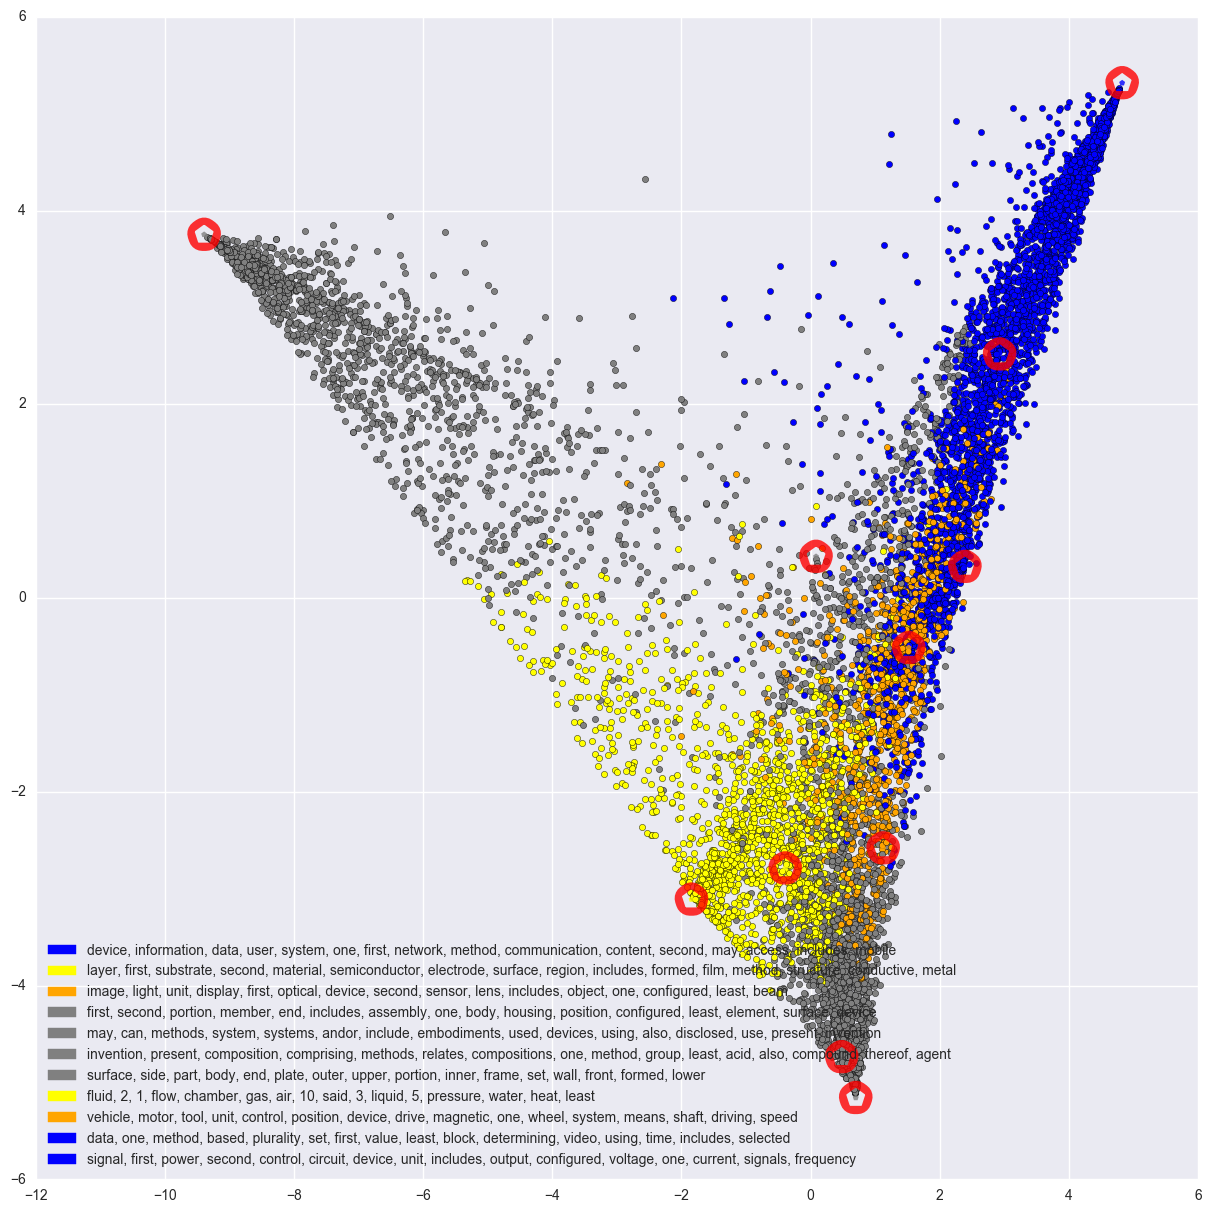

In [42]:
visualize_fischer_lda()

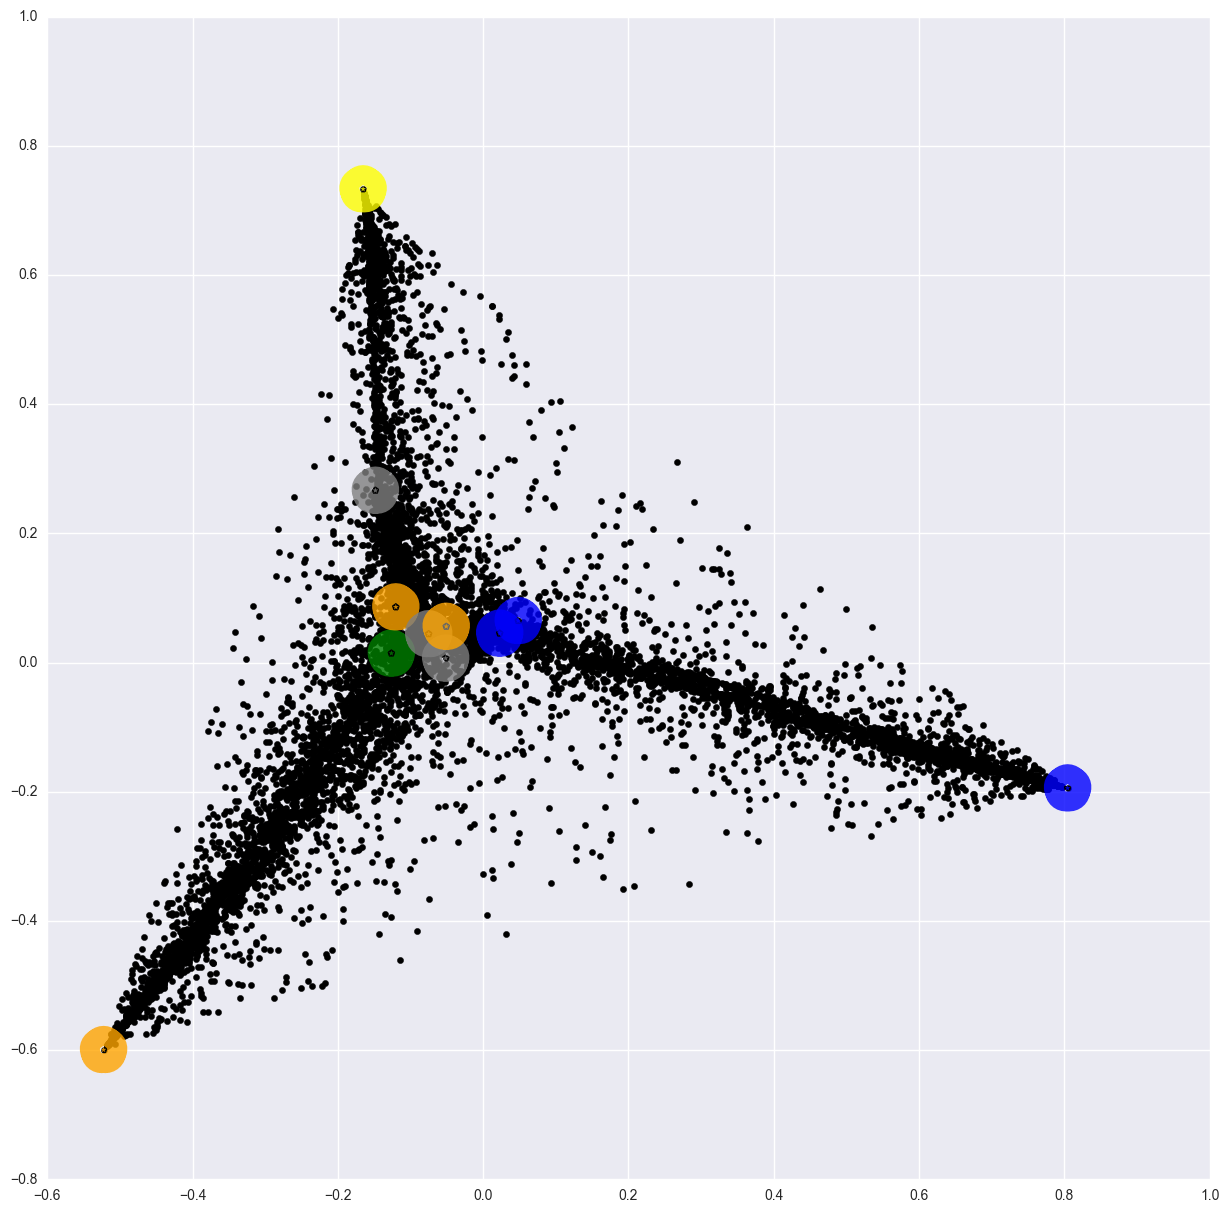

In [302]:
a = X.shape[0] - N_TOPICS
b = X.shape[0]
plt.figure(figsize=(15,15))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c="black")
plt.scatter(X_tsne[a:b,0], X_tsne[a:b,1], c=current_palette, marker="*", 
            linewidths=30, edgecolors=current_palette, alpha=0.8)
plt.show()

# Try to guess classes

In [322]:
def build_distance_matrix(data, mu):
    """build a distance matrix.
    return
        distance matrix:
            row of the matrix represents the data point,
            column of the matrix represents the k-th cluster.
    """
    distance_list = []
    num_cluster, _ = mu.shape
    for k_th in range(num_cluster):
        sum_squares = np.sum(np.square(data - mu[k_th, :]), axis=1)
        distance_list.append(sum_squares)
    return np.array(distance_list).T

In [323]:
distance_matrix = build_distance_matrix(X_tsne[0:len(data_en),:], X_tsne[a:b,:])
losses = np.min(distance_matrix, axis=1)
assignments = np.argmin(distance_matrix, axis=1)

In [324]:
assignments

array([6, 4, 2, ..., 3, 8, 5])

In [325]:
colors = [current_palette[a] for a in assignments]

In [326]:
colors[4]

'green'

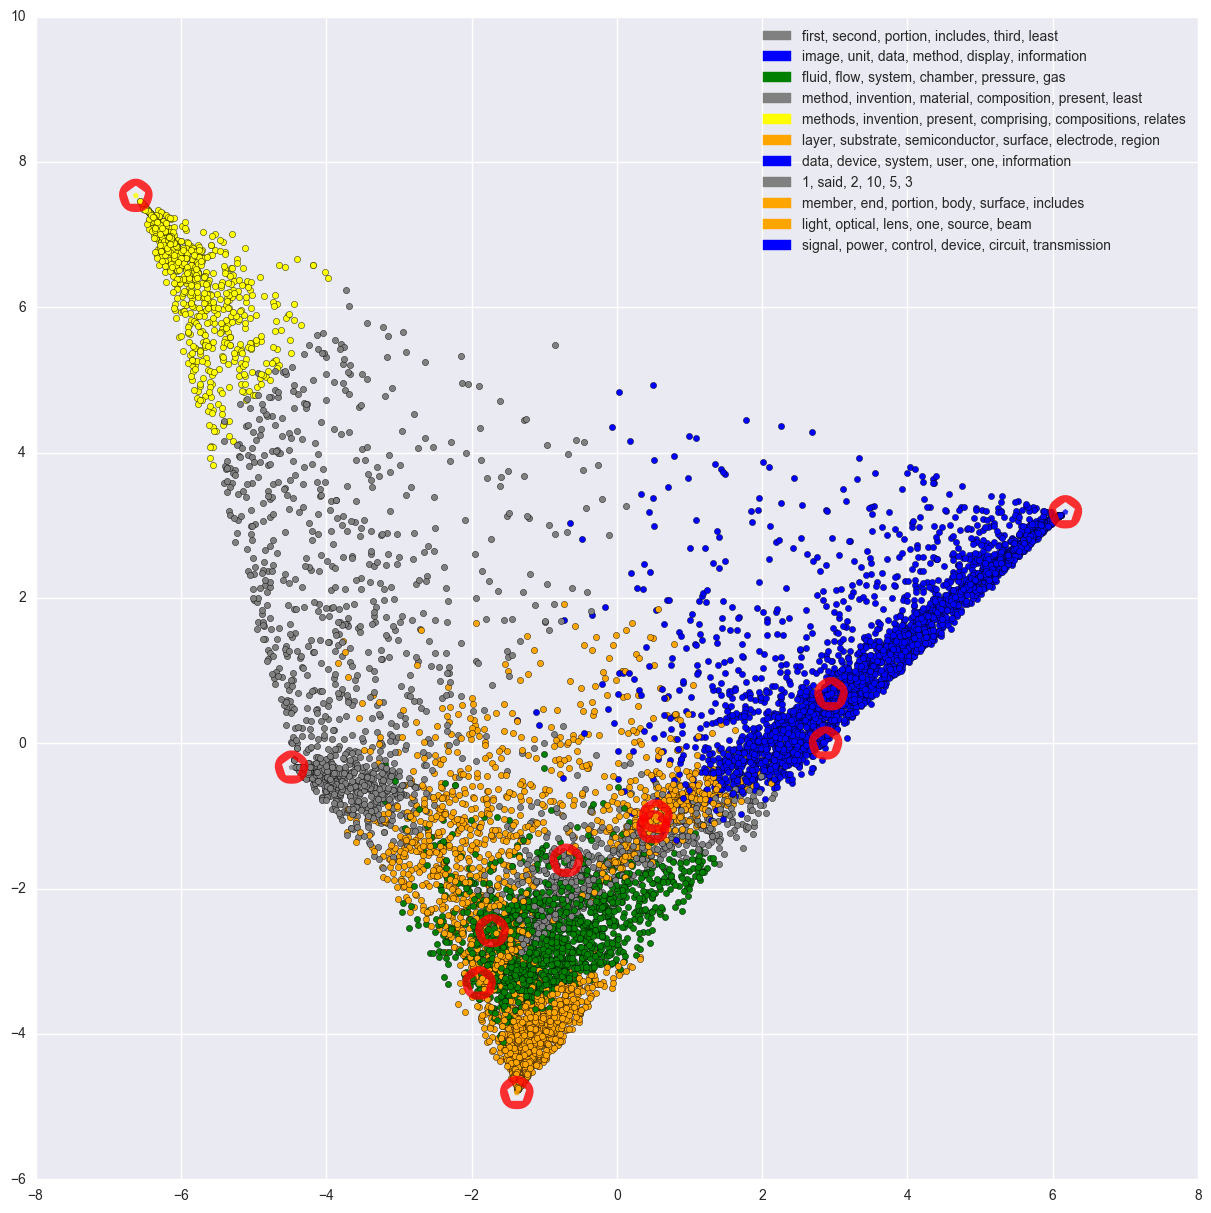

In [342]:
a = X.shape[0] - N_TOPICS
b = X.shape[0]
plt.figure(figsize=(15,15))
for i in range(len(data_en)):
    plt.scatter(X_tsne[i,0], X_tsne[i,1], c=colors[i])

    
plt.scatter(X_tsne[a:b,0], X_tsne[a:b,1], c=current_palette, marker="p", 
            linewidths=20, edgecolors="r", alpha=.8)

# doing the legend
import matplotlib.patches as mpatches
patches = []
for i,c in enumerate(current_palette):
    patches.append(mpatches.Patch(color=c, label=centroid_labels[i]))
plt.legend(handles=patches)
plt.show()

In [286]:
pd.Series(colors).value_counts()

gray      5172
orange    2043
yellow    1428
green      828
blue       529
dtype: int64

In [95]:
p.plot_height=800
p.plot_width=800
p.title.text = "What are the topics U.S Presidency candidates talk about ?"
p.title.text_font_size = "20pt"
# Turn off tick labels
p.axis.major_label_text_font_size = '0pt'  
# Turn off tick marks 
p.axis.major_tick_line_color = None  # turn off major ticks
p.axis[0].ticker.num_minor_ticks = 0  # turn off minor ticks
p.axis[1].ticker.num_minor_ticks = 0

# remove grids
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#legend
p.legend.orientation = "vertical"
p.legend.location = "bottom_right"
p.legend.background_fill_alpha = 1
p.legend.label_text_font = "Avenir"

In [96]:
show(p)

TypeError: 'NoneType' object is not iterable

In [68]:
from bokeh.embed import file_html
from bokeh.resources import CDN

html = file_html(p, CDN, "US Candidates topics")
with open("plot_US.html", "w") as f:
    f.write(html)

TypeError: 'NoneType' object is not iterable